### Importing necessary libraries

In [1]:
import pandas as pd
import os
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sentistrength import PySentiStr

import spacy
# Load the English language model with NER support
nlp = spacy.load("en_core_web_sm")

from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
import string

from sklearn.metrics.pairwise import cosine_similarity

### 1. First, download the dataset and arrange it in a way that would ease its manipulation and information retrieval task and save the dataset in excel file that highlights the political debate category, thread and messages. Write a script that generates overall statistics on the debates, indicating the number of threads per category and average number of discussion messages per thread for each category with the associated standard deviation and kurtosis. 

### Excel file creation

In [2]:
# a list to store data
data = []

# data directory
root_directory = 'F:/nlp/SomasundaranWiebe-politicalDebates'

# error counter to keep a check on the problems while reading the files
error_counter = 0

# going through the root directory and its subfolders
for root, dirs, files in os.walk(root_directory):
    for directory in dirs:
        # category name
        folder_name = os.path.basename(directory)
        
        folder_path = os.path.join(root, directory)

        # Initializing DataFrame to store the data within each folder
        thread_data = []

        # Iterating through files in the current subfolder
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)

            try:
                # Reading the content of the file (first attempt with utf-8 encoding)
                with open(file_path, 'r', encoding='utf-8') as file:
                    file_text = file.read()
                
                # stance and stance text patterns in regular expression
                stance_pattern = r'#stance=(\w+)'
                original_stance_text_pattern = r'#originalStanceText=(\w+)'
                
                # finding the stance and stance text regular expressions in the text and storing them
                stance_match = re.search(stance_pattern, file_text)
                original_stance_text_match = re.search(original_stance_text_pattern, file_text)
                
                if stance_match:
                    stance = stance_match.group(1)
                else:
                    stance = "Not Found"
                    error_counter += 1
                    
                if original_stance_text_match:
                    original_stance_text = original_stance_text_match.group(1)
                else:
                    original_stance_text = "Not Found"
                    error_counter += 1
                    
                # a regular expression to extract the "originalTopic" value
                thread_match = re.search(r'#originalTopic=(\S+)', file_text)
                if thread_match:
                    original_topic = thread_match.group(1)
                    # Find the position of the matched text and look for the next line and save the data
                    start_position = thread_match.end()
                    next_line_match = re.search(r'\n(.*)', file_text[start_position:])

                    if next_line_match:
                        next_line_text = next_line_match.group(1)

                        thread_data.append([folder_name, stance, original_stance_text, original_topic, next_line_text])
                    else:
                        error_counter += 1
                else:
                    error_counter += 1

            except Exception as e:
                # Read the content of the file (second attempt with iso-8859-1 encoding)
                with open(file_path, 'r', encoding='iso-8859-1') as file:
                    file_text = file.read()
                    
                # stance and stance text patterns in regular expression
                stance_pattern = r'#stance=(\w+)'
                original_stance_text_pattern = r'#originalStanceText=(\w+)'
                
                # finding the stance and stance text regular expressions in the text and storing them
                stance_match = re.search(stance_pattern, file_text)
                original_stance_text_match = re.search(original_stance_text_pattern, file_text)
                
                if stance_match:
                    stance = stance_match.group(1)
                else:
                    stance = "Not Found"
                    error_counter += 1
                    
                if original_stance_text_match:
                    original_stance_text = original_stance_text_match.group(1)
                else:
                    original_stance_text = "Not Found"
                    error_counter += 1
                    
                # Use a regular expression to extract the "originalTopic" value
                thread_match = re.search(r'#originalTopic=(\S+)', file_text)
                if thread_match:
                    original_topic = thread_match.group(1)
                    # Find the position of the matched text and look for the next line and save the data
                    start_position = thread_match.end()
                    next_line_match = re.search(r'\n(.*)', file_text[start_position:])

                    if next_line_match:
                        next_line_text = next_line_match.group(1)

                        thread_data.append([folder_name, stance, original_stance_text, original_topic, next_line_text])
                    else:
                        error_counter += 1
                else:
                    error_counter += 1
        # Append thread_data to the main data list
        data.extend(thread_data)

# Create a Pandas DataFrame from the collected data
df = pd.DataFrame(data, columns=['category', 'stance', 'stance_text', 'thread', 'message'])

df.to_excel('political_corpus_data.xlsx')


### Overall Satatistics Calculation

In [3]:
# Number of threads per category
grouped = df.groupby('category').agg(no_threads=('thread', 'nunique'))
no_threads_per_category = pd.DataFrame(grouped)
no_threads_per_category

,no_threads
category,
abortion,13
creation,15
gayRights,15
god,7
guns,18
healthcare,15


In [4]:
# Number of messages per thread in each category
message_counts = df.groupby(['category', 'thread'])['message'].count().reset_index()

message_counts = message_counts.rename(columns={'message': 'message_count'})
no_messages_per_thread = pd.DataFrame(message_counts)

no_messages_per_thread

,category,thread,message_count
0,abortion,Abortion_Should_Be_Banned,31
1,abortion,Are_you_Pro_Choice,42
2,abortion,Debate:_Abortion,136
3,abortion,Debate:_Partial-birth_abortion,33
4,abortion,If_abortion_was_illegal_should_it_still_be_leg...,53
...,...,...,...
78,healthcare,Universal_Health_Care_We_Should_Have_It,6
79,healthcare,Universal_Healthcare,58
80,healthcare,healthcare,38
81,healthcare,should-the-us-adopt-a-single-payer-health-care...,12


In [5]:
# Calculate the standard deviation and kurtosis for 'message_count'
std_dev = no_messages_per_thread['message_count'].std()

kurt = no_messages_per_thread['message_count'].kurtosis()

print(f'Standard Deviation: {std_dev}')
print(f'Kurtosis: {kurt}')

Standard Deviation: 106.56212016477134
Kurtosis: 8.682628025306158


### 2. Write a script that calculates the argument text length in terms of number of tokens for each discussion part and the average length (together with the associated standard deviation and kurtosis) per thread, then displays the distribution of average length per category. 

### Preprocessing

In [6]:
# Create a WordPunctTokenizer
tokenizer = WordPunctTokenizer()

# Stopwords and punctuation removal
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Remove underscores, spaces, hyphens, all kinds of brackets, including square brackets, curly brackets, and parentheses
    text = re.sub(r'[-_()\[\]{}<>\\/\s]', ' ', text)

    # Tokenize the text
    tokens = tokenizer.tokenize(text)

    # Stopword removal
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]

    # Punctuation and special character removal
    filtered_tokens = [word for word in filtered_tokens if word not in string.punctuation]

    # Join the filtered tokens back into a sentence
    filtered_text = ' '.join(filtered_tokens)

    return filtered_text

# Applying the preprocessing function to the 'Thread' column and create a new column 'thread_preprocessed'
preprocessed = []
for text in df["thread"]:
    after_preprocess = preprocess_text(text)
    preprocessed.append(after_preprocess)

df["thread_preprocessed"] = preprocessed

# Apply the preprocessing function to the 'message' column and create a new column 'message_preprocessed'
preprocessed = []
for text in df["message"]:
    after_preprocess = preprocess_text(text)
    preprocessed.append(after_preprocess)

df["message_preprocessed"] = preprocessed

In [7]:
# tokenizing the preprcessed messages
df['tokenized_message'] = df['message_preprocessed'].apply(nltk.word_tokenize)

# calculating the lengths of each tokenized message
df['tokenized_message_length'] = df['tokenized_message'].apply(len)

# initializing the summary statistics dataframe
summary_statistics_df = no_messages_per_thread.copy()

# token length, standard deviation and kurtosis calculation
total_token_length = []
standard_deviation = []
kurtosis = []

for unique_thread in summary_statistics_df['thread']:
    total_token_length.append(np.sum(df[df['thread'] == unique_thread]['tokenized_message_length']))
    standard_deviation.append(df[df['thread'] == unique_thread]['tokenized_message_length'].std())
    kurtosis.append(df[df['thread'] == unique_thread]['tokenized_message_length'].kurtosis())

    
summary_statistics_df['total_token_length'] = total_token_length
summary_statistics_df['standard_deviation'] = standard_deviation
summary_statistics_df['kurtosis'] = kurtosis

# average_token_length calculation and saving
def divide_columns(row):
    return row['total_token_length'] / row['message_count']

summary_statistics_df['average_token_length'] = summary_statistics_df.apply(divide_columns, axis = 1)

summary_statistics_df

,category,thread,message_count,total_token_length,standard_deviation,kurtosis,average_token_length
0,abortion,Abortion_Should_Be_Banned,31,641,23.295761,7.127121,20.677419
1,abortion,Are_you_Pro_Choice,42,1300,28.713006,6.452734,30.952381
2,abortion,Debate:_Abortion,136,5085,21.248502,1.912144,37.389706
3,abortion,Debate:_Partial-birth_abortion,33,1207,27.322187,-0.592999,36.575758
4,abortion,If_abortion_was_illegal_should_it_still_be_leg...,53,1686,39.961547,5.526138,31.811321
...,...,...,...,...,...,...,...
78,healthcare,Universal_Health_Care_We_Should_Have_It,6,373,69.780847,1.404326,62.166667
79,healthcare,Universal_Healthcare,58,6278,151.035410,14.709917,108.241379
80,healthcare,healthcare,38,2219,78.536113,12.553514,58.394737
81,healthcare,should-the-us-adopt-a-single-payer-health-care...,12,830,85.586568,9.640352,69.166667


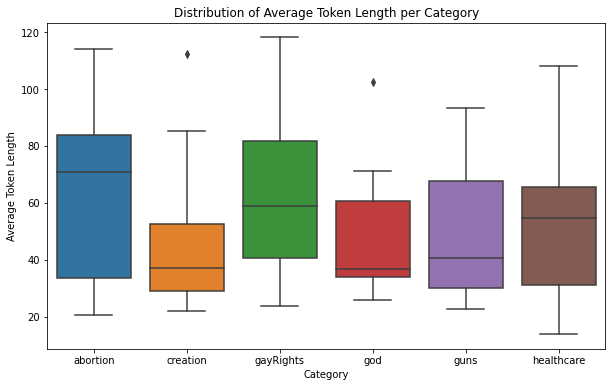

In [8]:
# displaying average token length per category
plt.figure(figsize=(10, 6))
sns.boxplot(x='category', y='average_token_length', data=summary_statistics_df)
plt.title('Distribution of Average Token Length per Category')
plt.xlabel('Category')
plt.ylabel('Average Token Length')
plt.show()

### 3. We want to elucidate the key players involved in the discussion parts in terms of key persons and organizations involved in shaping argument. Use SpaCy named-entity tagger to identify person and organization entities in the discussion parts. Suggest a script that outputs the histogram of the thirty most frequent named-entities for each category. 

In [9]:
# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Category', 'Stance', 'Post Count'])

for category in np.unique(df['category']):
    # Count the number of instances for stance1 and stance2 in each category
    count_stance1 = len(df[(df['category'] == category) & (df['stance'] == 'stance1')])
    count_stance2 = len(df[(df['category'] == category) & (df['stance'] == 'stance2')])
    
    # Append the results to the DataFrame
    results_df = results_df.append({'Category': category, 'Stance': 'stance1', 'Post Count': count_stance1}, ignore_index=True)
    results_df = results_df.append({'Category': category, 'Stance': 'stance2', 'Post Count': count_stance2}, ignore_index=True)

# Print the DataFrame
results_df

,Category,Stance,Post Count
0,abortion,stance1,631
1,abortion,stance2,520
2,creation,stance1,431
3,creation,stance2,799
4,gayRights,stance1,1321
5,gayRights,stance2,743
6,god,stance1,461
7,god,stance2,492
8,guns,stance1,774
9,guns,stance2,295


In [10]:
# creating list of named entities (all), locations, persons, organizations from all messages in the dataset
list_of_named_entities = []

locations = []
persons = []
organizations = []

n = 0
for message in df['message']:
    list_of_named_entities_this_row =[]
    locations_this_row = []
    persons_this_row = []
    organizations_this_row = []
    doc = nlp(message)
    
    for ent in doc.ents:
        list_of_named_entities_this_row.append(ent.text)
        
        if ent.label_ == "GPE":  # GPE represents geopolitical entity, i.e., location
            locations_this_row.append(ent.text)
        else:
            locations_this_row.append(0)
        if ent.label_ == "PERSON":
            persons_this_row.append(ent.text)
        else: 
            persons_this_row.append(0)
        if ent.label_ == "ORG":
            organizations_this_row.append(ent.text)
        else:
            organizations_this_row.append(0)
    print(f'{n} rows done')
    n+= 1
    list_of_named_entities.append(list_of_named_entities_this_row)
    locations.append(locations_this_row)
    persons.append(persons_this_row)
    organizations.append(organizations_this_row)

0 rows done
1 rows done
2 rows done
3 rows done
4 rows done
5 rows done
6 rows done
7 rows done
8 rows done
9 rows done
10 rows done
11 rows done
12 rows done
13 rows done
14 rows done
15 rows done
16 rows done
17 rows done
18 rows done
19 rows done
20 rows done
21 rows done
22 rows done
23 rows done
24 rows done
25 rows done
26 rows done
27 rows done
28 rows done
29 rows done
30 rows done
31 rows done
32 rows done
33 rows done
34 rows done
35 rows done
36 rows done
37 rows done
38 rows done
39 rows done
40 rows done
41 rows done
42 rows done
43 rows done
44 rows done
45 rows done
46 rows done
47 rows done
48 rows done
49 rows done
50 rows done
51 rows done
52 rows done
53 rows done
54 rows done
55 rows done
56 rows done
57 rows done
58 rows done
59 rows done
60 rows done
61 rows done
62 rows done
63 rows done
64 rows done
65 rows done
66 rows done
67 rows done
68 rows done
69 rows done
70 rows done
71 rows done
72 rows done
73 rows done
74 rows done
75 rows done
76 rows done
77 rows d

594 rows done
595 rows done
596 rows done
597 rows done
598 rows done
599 rows done
600 rows done
601 rows done
602 rows done
603 rows done
604 rows done
605 rows done
606 rows done
607 rows done
608 rows done
609 rows done
610 rows done
611 rows done
612 rows done
613 rows done
614 rows done
615 rows done
616 rows done
617 rows done
618 rows done
619 rows done
620 rows done
621 rows done
622 rows done
623 rows done
624 rows done
625 rows done
626 rows done
627 rows done
628 rows done
629 rows done
630 rows done
631 rows done
632 rows done
633 rows done
634 rows done
635 rows done
636 rows done
637 rows done
638 rows done
639 rows done
640 rows done
641 rows done
642 rows done
643 rows done
644 rows done
645 rows done
646 rows done
647 rows done
648 rows done
649 rows done
650 rows done
651 rows done
652 rows done
653 rows done
654 rows done
655 rows done
656 rows done
657 rows done
658 rows done
659 rows done
660 rows done
661 rows done
662 rows done
663 rows done
664 rows done
665 ro

1171 rows done
1172 rows done
1173 rows done
1174 rows done
1175 rows done
1176 rows done
1177 rows done
1178 rows done
1179 rows done
1180 rows done
1181 rows done
1182 rows done
1183 rows done
1184 rows done
1185 rows done
1186 rows done
1187 rows done
1188 rows done
1189 rows done
1190 rows done
1191 rows done
1192 rows done
1193 rows done
1194 rows done
1195 rows done
1196 rows done
1197 rows done
1198 rows done
1199 rows done
1200 rows done
1201 rows done
1202 rows done
1203 rows done
1204 rows done
1205 rows done
1206 rows done
1207 rows done
1208 rows done
1209 rows done
1210 rows done
1211 rows done
1212 rows done
1213 rows done
1214 rows done
1215 rows done
1216 rows done
1217 rows done
1218 rows done
1219 rows done
1220 rows done
1221 rows done
1222 rows done
1223 rows done
1224 rows done
1225 rows done
1226 rows done
1227 rows done
1228 rows done
1229 rows done
1230 rows done
1231 rows done
1232 rows done
1233 rows done
1234 rows done
1235 rows done
1236 rows done
1237 rows 

1721 rows done
1722 rows done
1723 rows done
1724 rows done
1725 rows done
1726 rows done
1727 rows done
1728 rows done
1729 rows done
1730 rows done
1731 rows done
1732 rows done
1733 rows done
1734 rows done
1735 rows done
1736 rows done
1737 rows done
1738 rows done
1739 rows done
1740 rows done
1741 rows done
1742 rows done
1743 rows done
1744 rows done
1745 rows done
1746 rows done
1747 rows done
1748 rows done
1749 rows done
1750 rows done
1751 rows done
1752 rows done
1753 rows done
1754 rows done
1755 rows done
1756 rows done
1757 rows done
1758 rows done
1759 rows done
1760 rows done
1761 rows done
1762 rows done
1763 rows done
1764 rows done
1765 rows done
1766 rows done
1767 rows done
1768 rows done
1769 rows done
1770 rows done
1771 rows done
1772 rows done
1773 rows done
1774 rows done
1775 rows done
1776 rows done
1777 rows done
1778 rows done
1779 rows done
1780 rows done
1781 rows done
1782 rows done
1783 rows done
1784 rows done
1785 rows done
1786 rows done
1787 rows 

2268 rows done
2269 rows done
2270 rows done
2271 rows done
2272 rows done
2273 rows done
2274 rows done
2275 rows done
2276 rows done
2277 rows done
2278 rows done
2279 rows done
2280 rows done
2281 rows done
2282 rows done
2283 rows done
2284 rows done
2285 rows done
2286 rows done
2287 rows done
2288 rows done
2289 rows done
2290 rows done
2291 rows done
2292 rows done
2293 rows done
2294 rows done
2295 rows done
2296 rows done
2297 rows done
2298 rows done
2299 rows done
2300 rows done
2301 rows done
2302 rows done
2303 rows done
2304 rows done
2305 rows done
2306 rows done
2307 rows done
2308 rows done
2309 rows done
2310 rows done
2311 rows done
2312 rows done
2313 rows done
2314 rows done
2315 rows done
2316 rows done
2317 rows done
2318 rows done
2319 rows done
2320 rows done
2321 rows done
2322 rows done
2323 rows done
2324 rows done
2325 rows done
2326 rows done
2327 rows done
2328 rows done
2329 rows done
2330 rows done
2331 rows done
2332 rows done
2333 rows done
2334 rows 

2819 rows done
2820 rows done
2821 rows done
2822 rows done
2823 rows done
2824 rows done
2825 rows done
2826 rows done
2827 rows done
2828 rows done
2829 rows done
2830 rows done
2831 rows done
2832 rows done
2833 rows done
2834 rows done
2835 rows done
2836 rows done
2837 rows done
2838 rows done
2839 rows done
2840 rows done
2841 rows done
2842 rows done
2843 rows done
2844 rows done
2845 rows done
2846 rows done
2847 rows done
2848 rows done
2849 rows done
2850 rows done
2851 rows done
2852 rows done
2853 rows done
2854 rows done
2855 rows done
2856 rows done
2857 rows done
2858 rows done
2859 rows done
2860 rows done
2861 rows done
2862 rows done
2863 rows done
2864 rows done
2865 rows done
2866 rows done
2867 rows done
2868 rows done
2869 rows done
2870 rows done
2871 rows done
2872 rows done
2873 rows done
2874 rows done
2875 rows done
2876 rows done
2877 rows done
2878 rows done
2879 rows done
2880 rows done
2881 rows done
2882 rows done
2883 rows done
2884 rows done
2885 rows 

3369 rows done
3370 rows done
3371 rows done
3372 rows done
3373 rows done
3374 rows done
3375 rows done
3376 rows done
3377 rows done
3378 rows done
3379 rows done
3380 rows done
3381 rows done
3382 rows done
3383 rows done
3384 rows done
3385 rows done
3386 rows done
3387 rows done
3388 rows done
3389 rows done
3390 rows done
3391 rows done
3392 rows done
3393 rows done
3394 rows done
3395 rows done
3396 rows done
3397 rows done
3398 rows done
3399 rows done
3400 rows done
3401 rows done
3402 rows done
3403 rows done
3404 rows done
3405 rows done
3406 rows done
3407 rows done
3408 rows done
3409 rows done
3410 rows done
3411 rows done
3412 rows done
3413 rows done
3414 rows done
3415 rows done
3416 rows done
3417 rows done
3418 rows done
3419 rows done
3420 rows done
3421 rows done
3422 rows done
3423 rows done
3424 rows done
3425 rows done
3426 rows done
3427 rows done
3428 rows done
3429 rows done
3430 rows done
3431 rows done
3432 rows done
3433 rows done
3434 rows done
3435 rows 

3923 rows done
3924 rows done
3925 rows done
3926 rows done
3927 rows done
3928 rows done
3929 rows done
3930 rows done
3931 rows done
3932 rows done
3933 rows done
3934 rows done
3935 rows done
3936 rows done
3937 rows done
3938 rows done
3939 rows done
3940 rows done
3941 rows done
3942 rows done
3943 rows done
3944 rows done
3945 rows done
3946 rows done
3947 rows done
3948 rows done
3949 rows done
3950 rows done
3951 rows done
3952 rows done
3953 rows done
3954 rows done
3955 rows done
3956 rows done
3957 rows done
3958 rows done
3959 rows done
3960 rows done
3961 rows done
3962 rows done
3963 rows done
3964 rows done
3965 rows done
3966 rows done
3967 rows done
3968 rows done
3969 rows done
3970 rows done
3971 rows done
3972 rows done
3973 rows done
3974 rows done
3975 rows done
3976 rows done
3977 rows done
3978 rows done
3979 rows done
3980 rows done
3981 rows done
3982 rows done
3983 rows done
3984 rows done
3985 rows done
3986 rows done
3987 rows done
3988 rows done
3989 rows 

4471 rows done
4472 rows done
4473 rows done
4474 rows done
4475 rows done
4476 rows done
4477 rows done
4478 rows done
4479 rows done
4480 rows done
4481 rows done
4482 rows done
4483 rows done
4484 rows done
4485 rows done
4486 rows done
4487 rows done
4488 rows done
4489 rows done
4490 rows done
4491 rows done
4492 rows done
4493 rows done
4494 rows done
4495 rows done
4496 rows done
4497 rows done
4498 rows done
4499 rows done
4500 rows done
4501 rows done
4502 rows done
4503 rows done
4504 rows done
4505 rows done
4506 rows done
4507 rows done
4508 rows done
4509 rows done
4510 rows done
4511 rows done
4512 rows done
4513 rows done
4514 rows done
4515 rows done
4516 rows done
4517 rows done
4518 rows done
4519 rows done
4520 rows done
4521 rows done
4522 rows done
4523 rows done
4524 rows done
4525 rows done
4526 rows done
4527 rows done
4528 rows done
4529 rows done
4530 rows done
4531 rows done
4532 rows done
4533 rows done
4534 rows done
4535 rows done
4536 rows done
4537 rows 

5020 rows done
5021 rows done
5022 rows done
5023 rows done
5024 rows done
5025 rows done
5026 rows done
5027 rows done
5028 rows done
5029 rows done
5030 rows done
5031 rows done
5032 rows done
5033 rows done
5034 rows done
5035 rows done
5036 rows done
5037 rows done
5038 rows done
5039 rows done
5040 rows done
5041 rows done
5042 rows done
5043 rows done
5044 rows done
5045 rows done
5046 rows done
5047 rows done
5048 rows done
5049 rows done
5050 rows done
5051 rows done
5052 rows done
5053 rows done
5054 rows done
5055 rows done
5056 rows done
5057 rows done
5058 rows done
5059 rows done
5060 rows done
5061 rows done
5062 rows done
5063 rows done
5064 rows done
5065 rows done
5066 rows done
5067 rows done
5068 rows done
5069 rows done
5070 rows done
5071 rows done
5072 rows done
5073 rows done
5074 rows done
5075 rows done
5076 rows done
5077 rows done
5078 rows done
5079 rows done
5080 rows done
5081 rows done
5082 rows done
5083 rows done
5084 rows done
5085 rows done
5086 rows 

5571 rows done
5572 rows done
5573 rows done
5574 rows done
5575 rows done
5576 rows done
5577 rows done
5578 rows done
5579 rows done
5580 rows done
5581 rows done
5582 rows done
5583 rows done
5584 rows done
5585 rows done
5586 rows done
5587 rows done
5588 rows done
5589 rows done
5590 rows done
5591 rows done
5592 rows done
5593 rows done
5594 rows done
5595 rows done
5596 rows done
5597 rows done
5598 rows done
5599 rows done
5600 rows done
5601 rows done
5602 rows done
5603 rows done
5604 rows done
5605 rows done
5606 rows done
5607 rows done
5608 rows done
5609 rows done
5610 rows done
5611 rows done
5612 rows done
5613 rows done
5614 rows done
5615 rows done
5616 rows done
5617 rows done
5618 rows done
5619 rows done
5620 rows done
5621 rows done
5622 rows done
5623 rows done
5624 rows done
5625 rows done
5626 rows done
5627 rows done
5628 rows done
5629 rows done
5630 rows done
5631 rows done
5632 rows done
5633 rows done
5634 rows done
5635 rows done
5636 rows done
5637 rows 

6119 rows done
6120 rows done
6121 rows done
6122 rows done
6123 rows done
6124 rows done
6125 rows done
6126 rows done
6127 rows done
6128 rows done
6129 rows done
6130 rows done
6131 rows done
6132 rows done
6133 rows done
6134 rows done
6135 rows done
6136 rows done
6137 rows done
6138 rows done
6139 rows done
6140 rows done
6141 rows done
6142 rows done
6143 rows done
6144 rows done
6145 rows done
6146 rows done
6147 rows done
6148 rows done
6149 rows done
6150 rows done
6151 rows done
6152 rows done
6153 rows done
6154 rows done
6155 rows done
6156 rows done
6157 rows done
6158 rows done
6159 rows done
6160 rows done
6161 rows done
6162 rows done
6163 rows done
6164 rows done
6165 rows done
6166 rows done
6167 rows done
6168 rows done
6169 rows done
6170 rows done
6171 rows done
6172 rows done
6173 rows done
6174 rows done
6175 rows done
6176 rows done
6177 rows done
6178 rows done
6179 rows done
6180 rows done
6181 rows done
6182 rows done
6183 rows done
6184 rows done
6185 rows 

6666 rows done
6667 rows done
6668 rows done
6669 rows done
6670 rows done
6671 rows done
6672 rows done
6673 rows done
6674 rows done
6675 rows done
6676 rows done
6677 rows done
6678 rows done
6679 rows done
6680 rows done
6681 rows done
6682 rows done
6683 rows done
6684 rows done
6685 rows done
6686 rows done
6687 rows done
6688 rows done
6689 rows done
6690 rows done
6691 rows done
6692 rows done
6693 rows done
6694 rows done
6695 rows done
6696 rows done
6697 rows done
6698 rows done
6699 rows done
6700 rows done
6701 rows done
6702 rows done
6703 rows done
6704 rows done
6705 rows done
6706 rows done
6707 rows done
6708 rows done
6709 rows done
6710 rows done
6711 rows done
6712 rows done
6713 rows done
6714 rows done
6715 rows done
6716 rows done
6717 rows done
6718 rows done
6719 rows done
6720 rows done
6721 rows done
6722 rows done
6723 rows done
6724 rows done
6725 rows done
6726 rows done
6727 rows done
6728 rows done
6729 rows done
6730 rows done
6731 rows done
6732 rows 

In [11]:
# saving the named entities in the dataframe in separate columns
df['named_entities'] = list_of_named_entities
df['named_entities_location'] = locations
df['named_entities_persons'] = persons
df['named_entities_organizations'] = organizations

In [12]:
# function for finding the top 30 named entities for overall, stance 1 and stance 2
def top_30_ner_finding(ner_type):
    top_30_ner_dictionary = {}
    top_30_ner_dictionary_for_stance1 = {}
    top_30_ner_dictionary_for_stance2 = {}
    
    for category in np.unique(df['category']):
        # storing all named entities in lists - one for overall, one for stance 1 and one for stance 2
        all_entities = [entity for entities_list in df[df['category'] == category][ner_type] for entity in entities_list]
        all_entities_stance1 = [entity for entities_list in df[(df['category'] == category) & (df['stance'] == 'stance1')][ner_type] for entity in entities_list]
        all_entities_stance2 = [entity for entities_list in df[(df['category'] == category) & (df['stance'] == 'stance2')][ner_type] for entity in entities_list]

        # Counting the frequency of each named entity
        entity_counts = Counter(all_entities)
        entity_counts_stance1 = Counter(all_entities_stance1)
        entity_counts_stance2 = Counter(all_entities_stance2)

        # Sorting the named entities by frequency in descending order
        sorted_entities = sorted(entity_counts.items(), key=lambda x: x[1], reverse=True)
        sorted_entities_stance1 = sorted(entity_counts_stance1.items(), key=lambda x: x[1], reverse=True)
        sorted_entities_stance2 = sorted(entity_counts_stance2.items(), key=lambda x: x[1], reverse=True)

        # Selecting the top 30 named entities
        top_30_entities = sorted_entities[1:31]
        top_30_entities_stance1 = sorted_entities_stance1[1:31]
        top_30_entities_stance2 = sorted_entities_stance2[1:31]

        top_30_ner_dictionary[category] = top_30_entities
        top_30_ner_dictionary_for_stance1[category] = top_30_entities_stance1
        top_30_ner_dictionary_for_stance2[category] = top_30_entities_stance2
        
    return top_30_ner_dictionary, top_30_ner_dictionary_for_stance1, top_30_ner_dictionary_for_stance2
    

In [13]:
# top 30 named entities for whole dataset, for pro stances and con stances separately
top_30_ner_dictionary, top_30_ner_dictionary_for_stance1, top_30_ner_dictionary_for_stance2 = top_30_ner_finding('named_entities')

# top 30 locations for whole dataset, for pro stances and con stances separately
top_30_locations_dictionary, top_30_locations_dictionary_for_stance1, top_30_locations_dictionary_for_stance2 = top_30_ner_finding('named_entities_location')

# top 30 persons for whole dataset, for pro stances and con stances separately
top_30_persons_dictionary, top_30_persons_dictionary_for_stance1, top_30_persons_dictionary_for_stance2 = top_30_ner_finding('named_entities_persons')

# top 30 organizations for whole dataset, for pro stances and con stances separately
top_30_organizations_dictionary, top_30_organizations_dictionary_for_stance1, top_30_organizations_dictionary_for_stance2 = top_30_ner_finding('named_entities_organizations')

In [14]:
# calculating the number of pro, con labeled posts, number of locaitons, persons and organizations mentioned

# Function for finding unique named entities in a list, ignoring 0 values
def unique_strings_in_list(lst):
    unique_strings = set(item for item in lst if item != 0)
    return len(unique_strings)

# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Category', 'Stance', 'Post Count', 'No. Locations', 'No. Organizations', 'No. Persons'])

for category in np.unique(df['category']):
    for stance in ['stance1', 'stance2']:
        filtered_df = df[(df['category'] == category) & (df['stance'] == stance)]

        count_stance = len(filtered_df)
        no_persons = unique_strings_in_list(filtered_df['named_entities_persons'].explode().tolist())
        no_locations = unique_strings_in_list(filtered_df['named_entities_location'].explode().tolist())
        no_organizations = unique_strings_in_list(filtered_df['named_entities_organizations'].explode().tolist())

        results_df = results_df.append({
            'Category': category,
            'Stance': stance,
            'Post Count': count_stance,
            'No. Locations': no_locations,
            'No. Organizations': no_organizations,
            'No. Persons': no_persons
        }, ignore_index=True)

results_df.reset_index(drop=True, inplace=True)

results_df

,Category,Stance,Post Count,No. Locations,No. Organizations,No. Persons
0,abortion,stance1,631,58,152,153
1,abortion,stance2,520,56,187,178
2,creation,stance1,431,64,291,253
3,creation,stance2,799,126,528,440
4,gayRights,stance1,1321,188,529,508
5,gayRights,stance2,743,153,346,364
6,god,stance1,461,59,164,140
7,god,stance2,492,74,165,167
8,guns,stance1,774,154,349,255
9,guns,stance2,295,70,95,70


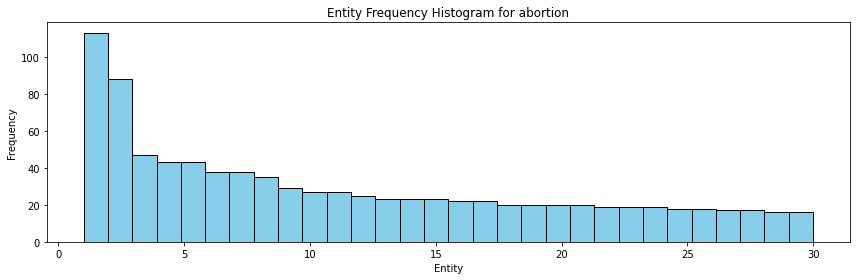

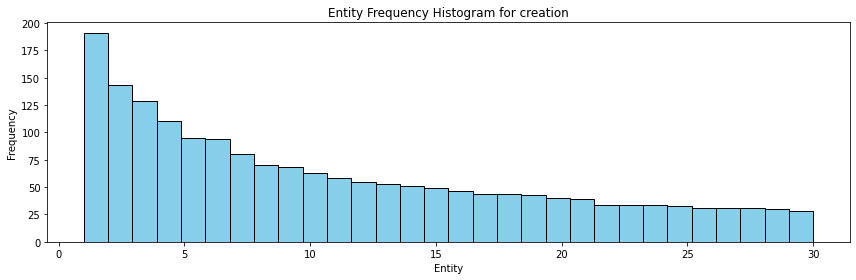

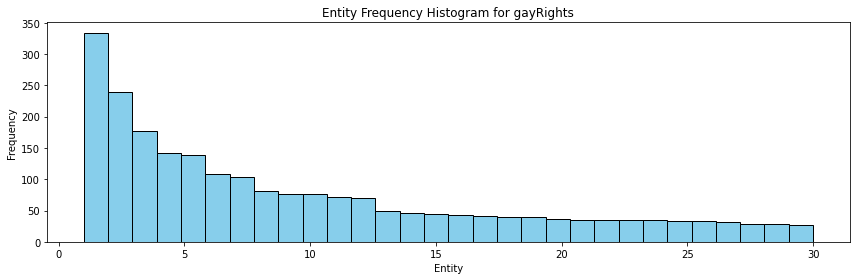

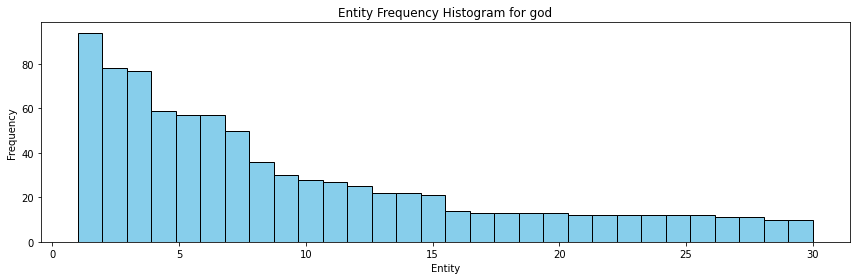

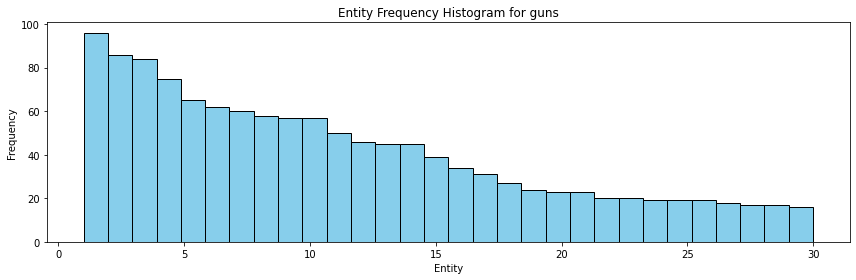

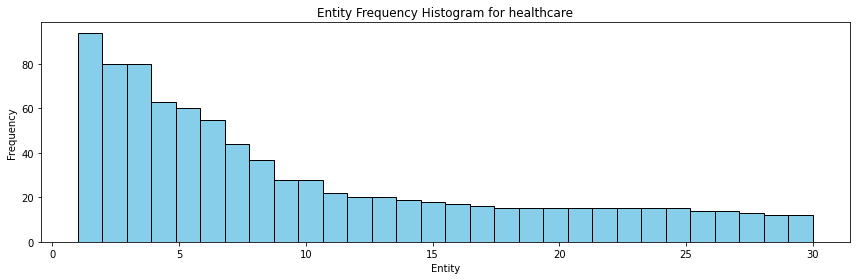

In [15]:
for category in top_30_ner_dictionary.keys():
    # Extract the frequencies of entities
    frequencies = [freq for _, freq in top_30_ner_dictionary[category]]

    # Create a histogram with heights representing frequencies
    plt.figure(figsize=(12, 4))
    plt.hist(range(1, len(frequencies) + 1), bins=len(frequencies), color='skyblue', edgecolor='black', weights=frequencies)
    plt.ylabel('Frequency')  # Set the y-axis label
    plt.xlabel('Entity')  # Set the x-axis label
    plt.title(f'Entity Frequency Histogram for {category}')
    plt.tight_layout()

    # Show the histogram
    plt.show()


### 4. We want to distinguish Pro and Con arguments. Therefore, repeat 3) by separating discussion parts held in Pro and those discussions held in Con label. 

In [16]:
# function for creating frequency histograms for pro and con labeled named entities

def ner_plot_per_stance(ner_dictionary, ner_dictionary_stance1, ner_dictionary_stance2, entity_type):
    for i, category in enumerate(ner_dictionary.keys()):
        fig, axs = plt.subplots(1, 1, figsize=(15, 5))

        # Extract the frequencies of entities for both stances
        frequencies_stance1 = [freq for _, freq in ner_dictionary_stance1[category]]
        frequencies_stance2 = [freq for _, freq in ner_dictionary_stance2[category]]

        # Create a histogram in the subplot
        axs.hist(
            [range(1, len(frequencies_stance1) + 1), range(1, len(frequencies_stance2) + 1)],
            bins=len(frequencies_stance1),
            color=['lightgreen', 'salmon'],
            edgecolor='black',
            weights=[frequencies_stance1, frequencies_stance2]
        )

        axs.set_ylabel('Frequency')
        axs.set_xlabel(entity_type)
        axs.set_title(f'{entity_type} Frequency Histogram for {category}')

        # Create a legend for 'Pro' and 'Con'
        axs.legend(['Pro', 'Con'])

        # Adjust the layout
        plt.tight_layout()

        # Show the subplot
        plt.show()
    return

### For Overall dataset

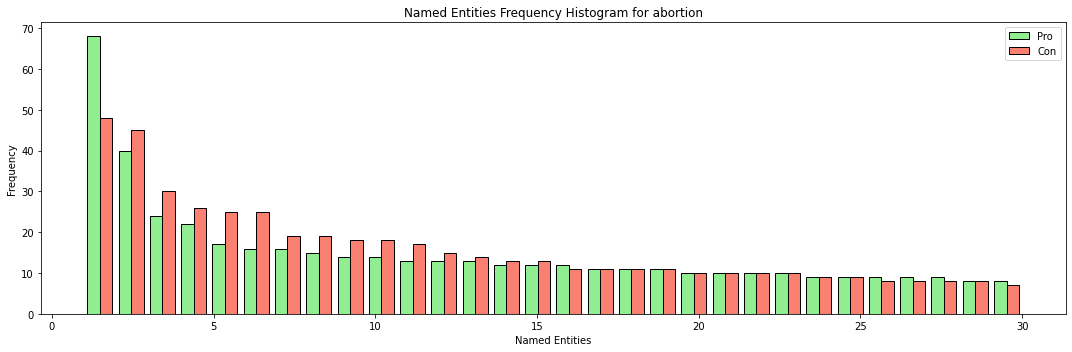

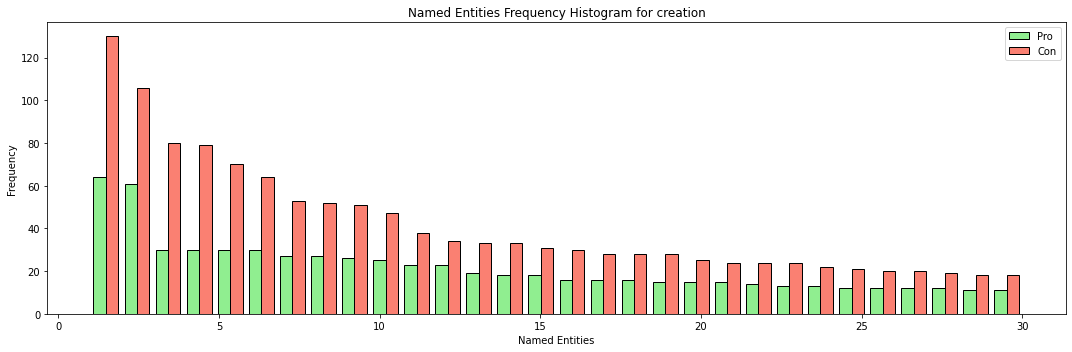

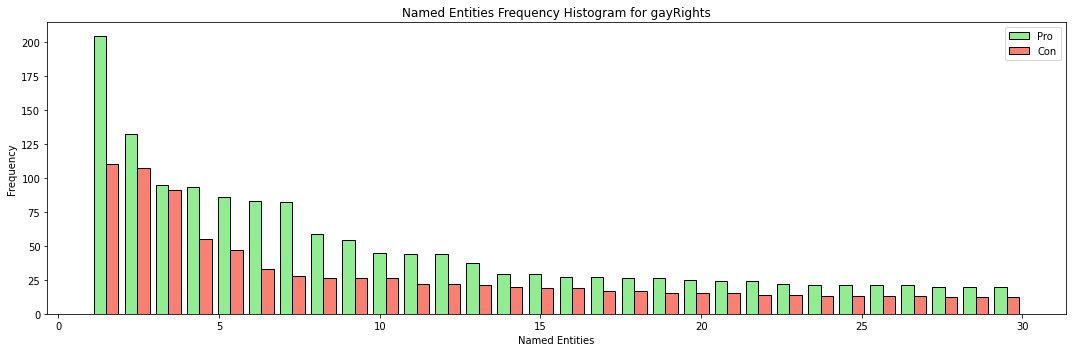

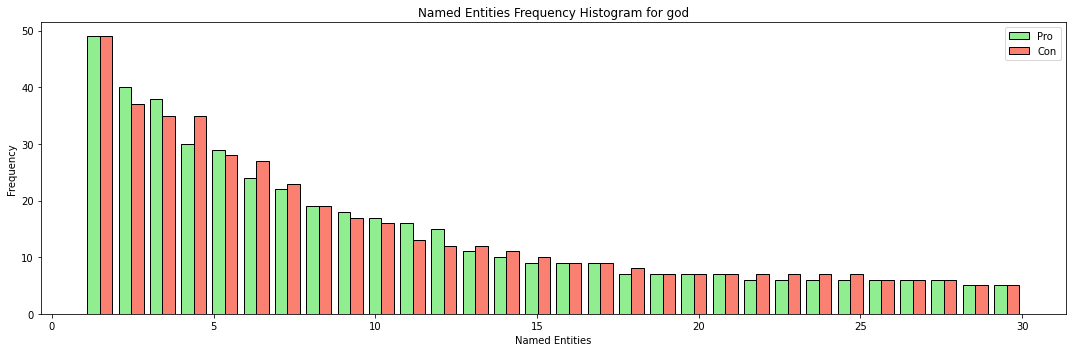

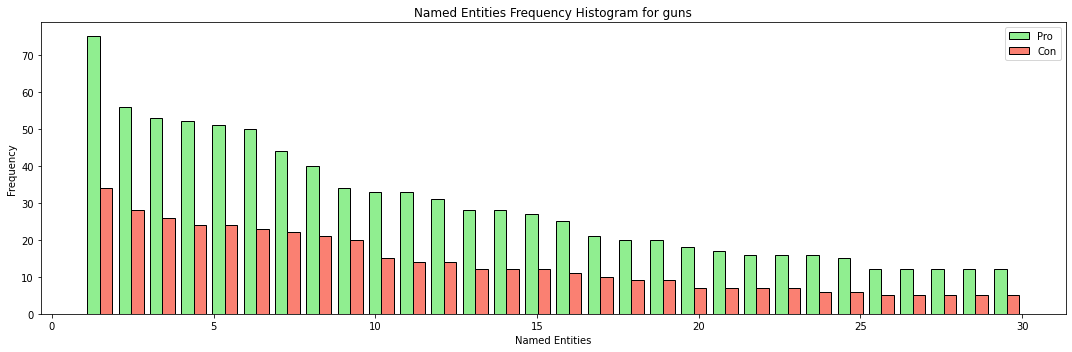

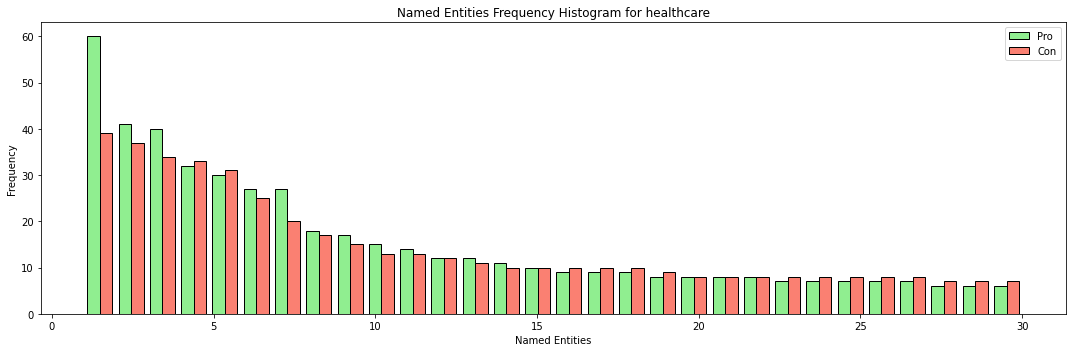

In [17]:
ner_plot_per_stance(top_30_ner_dictionary, top_30_ner_dictionary_for_stance1, top_30_ner_dictionary_for_stance2, 'Named Entities')

### For Locations

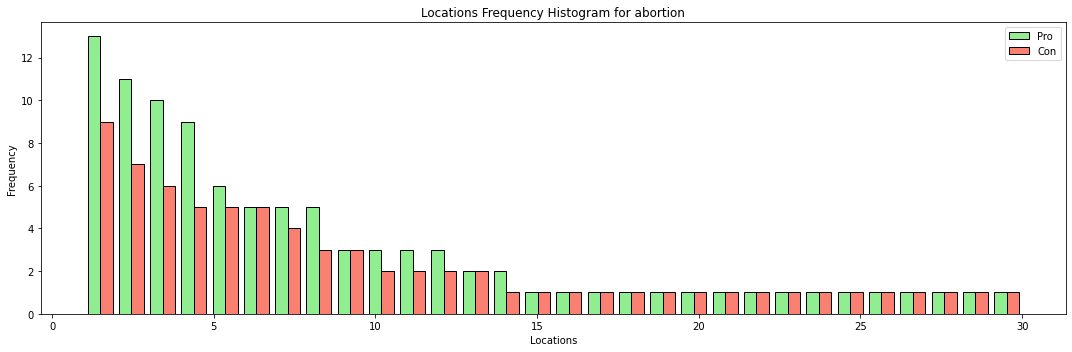

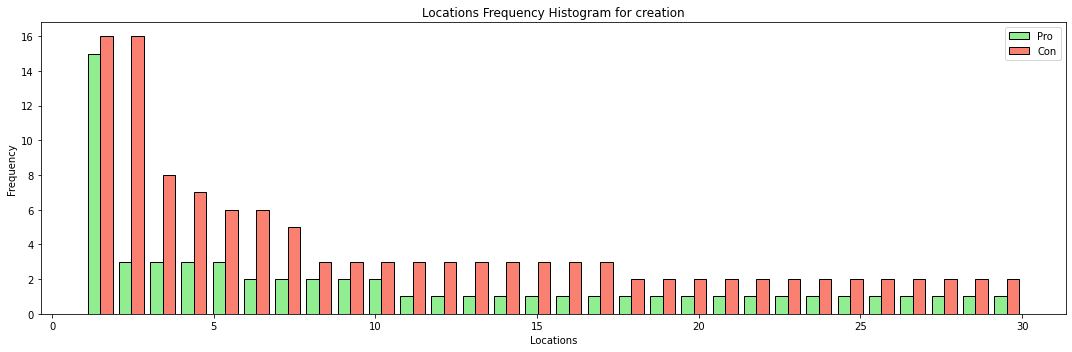

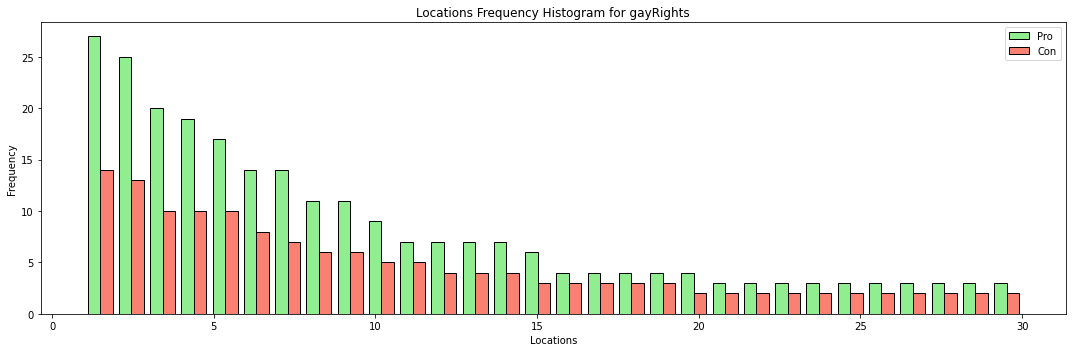

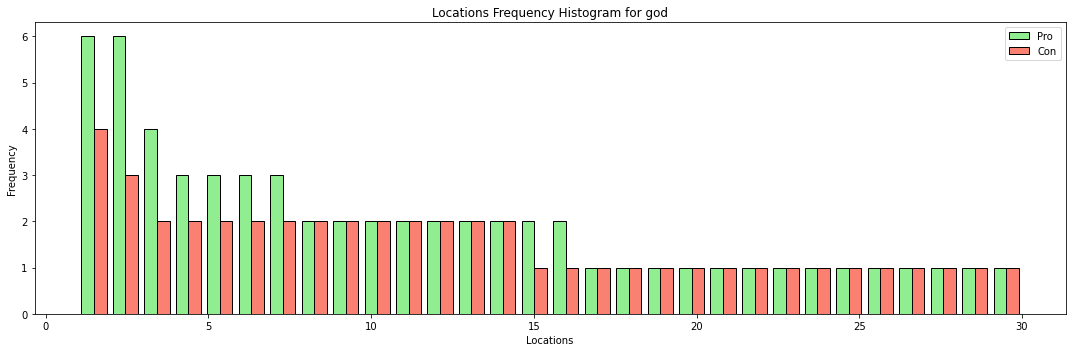

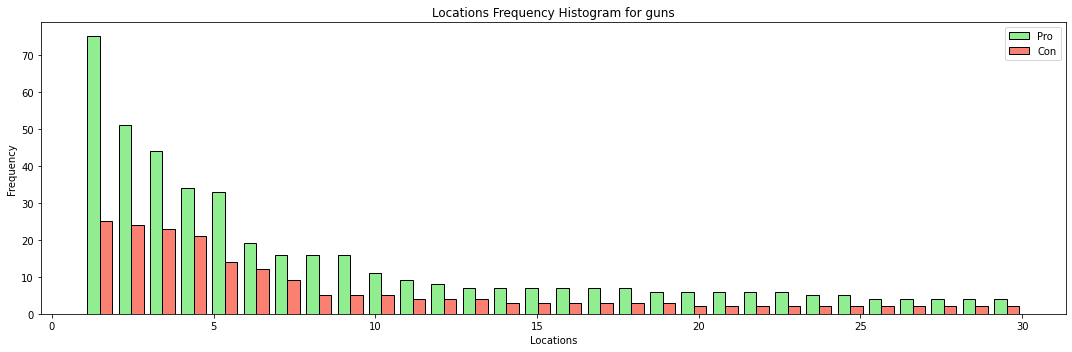

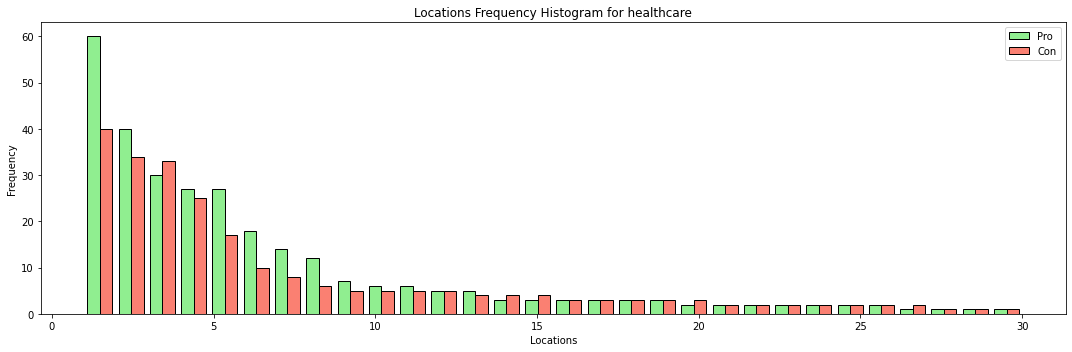

In [18]:
ner_plot_per_stance(top_30_locations_dictionary, top_30_locations_dictionary_for_stance1, top_30_locations_dictionary_for_stance2, 'Locations')

### For Persons

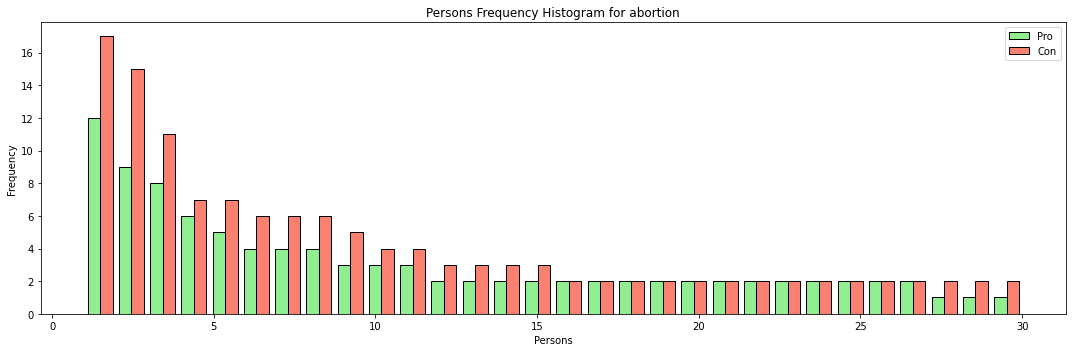

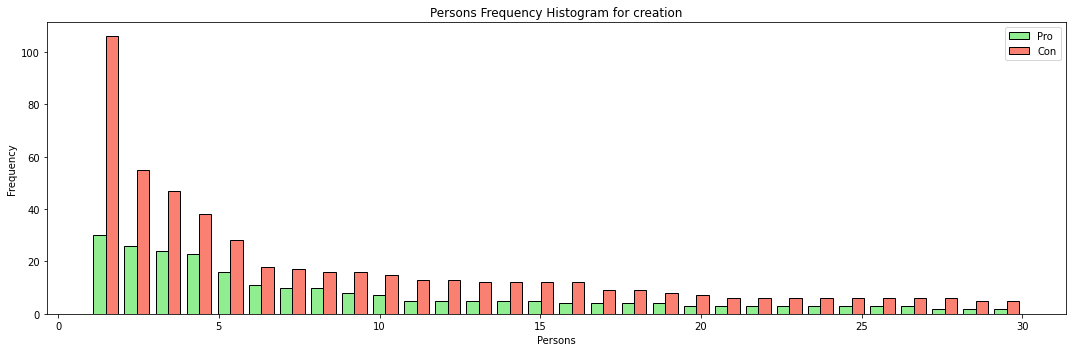

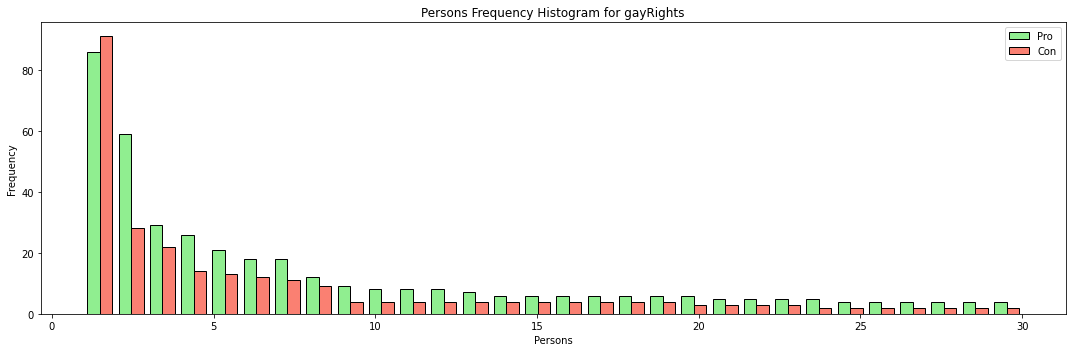

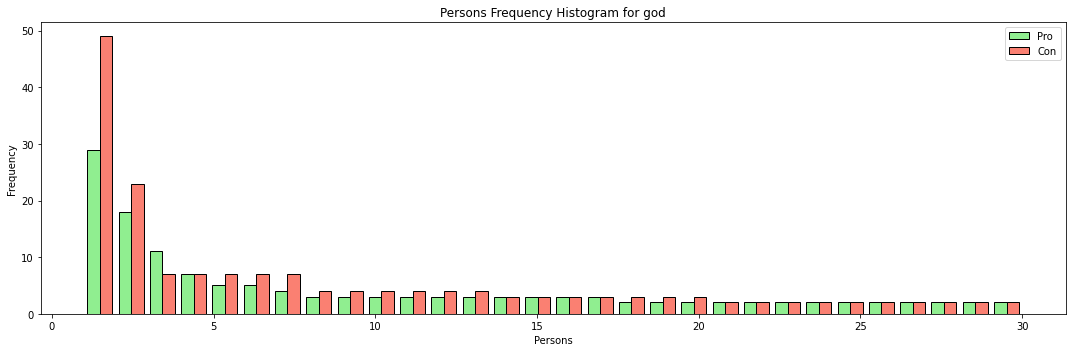

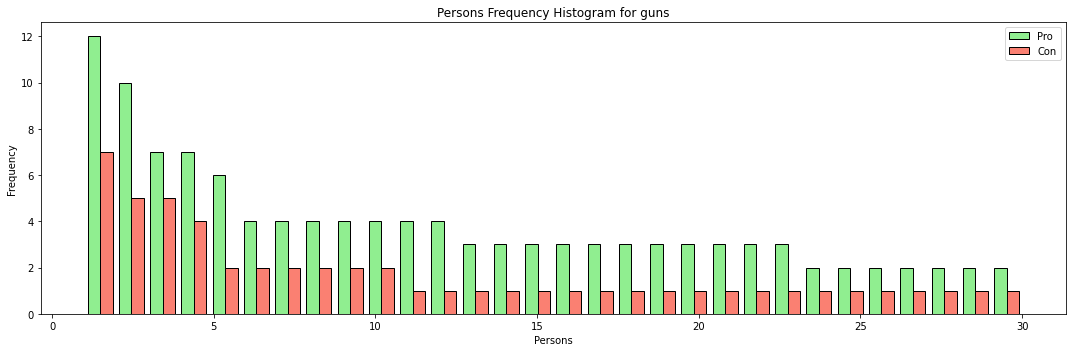

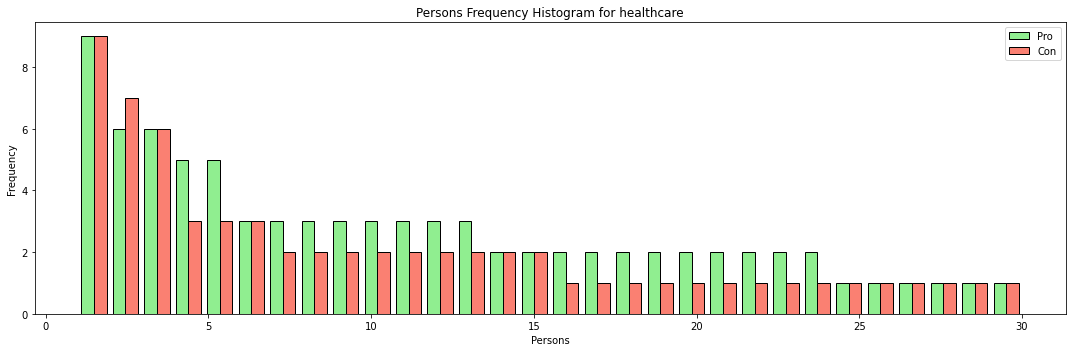

In [19]:
ner_plot_per_stance(top_30_persons_dictionary, top_30_persons_dictionary_for_stance1, top_30_persons_dictionary_for_stance2, 'Persons')

### For Organizations

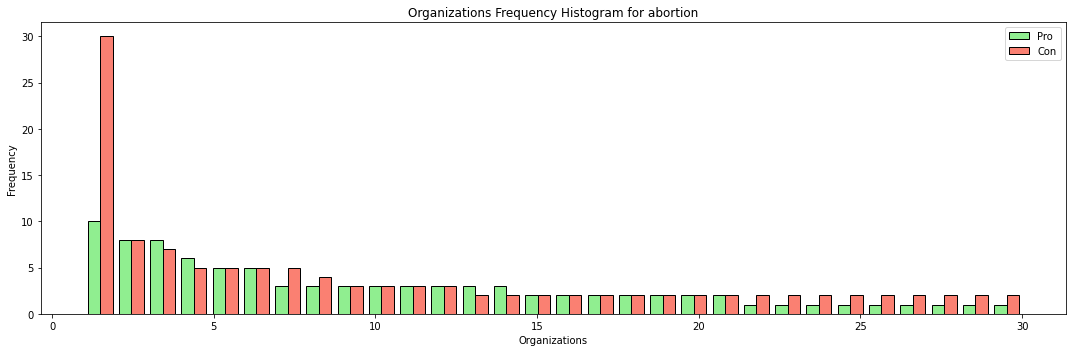

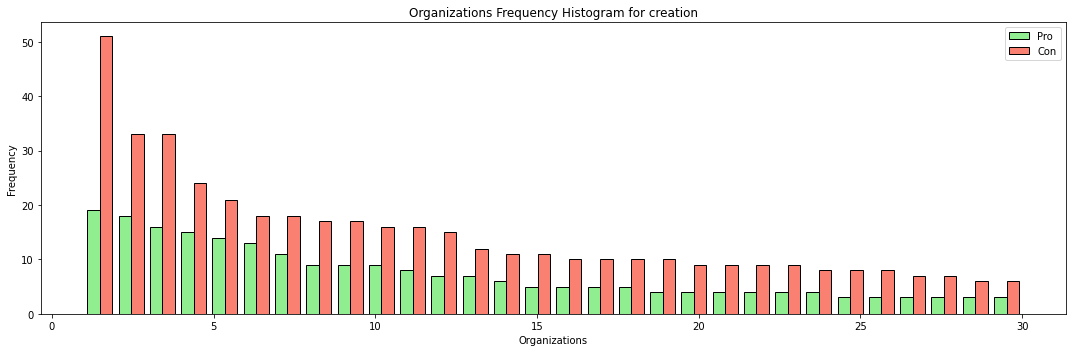

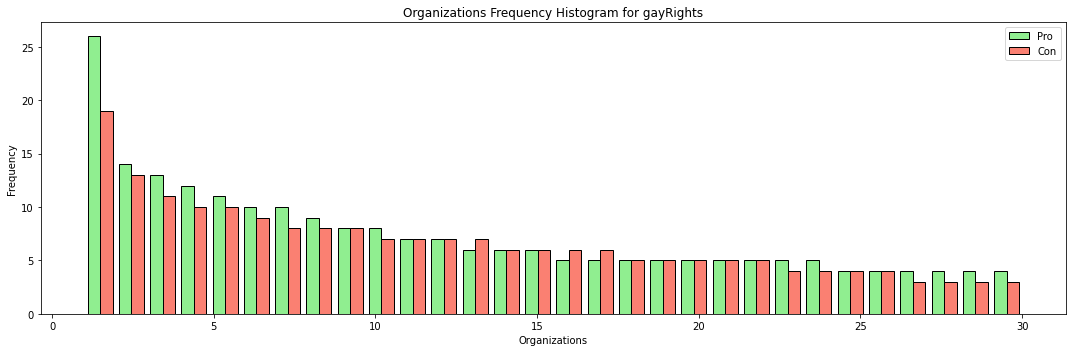

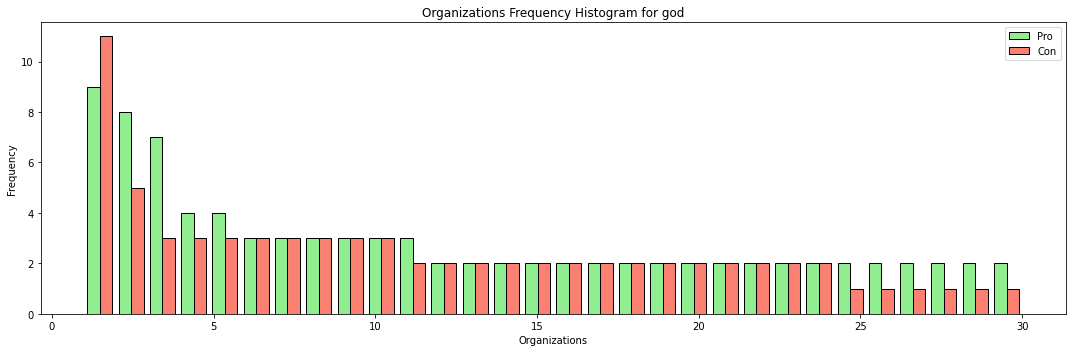

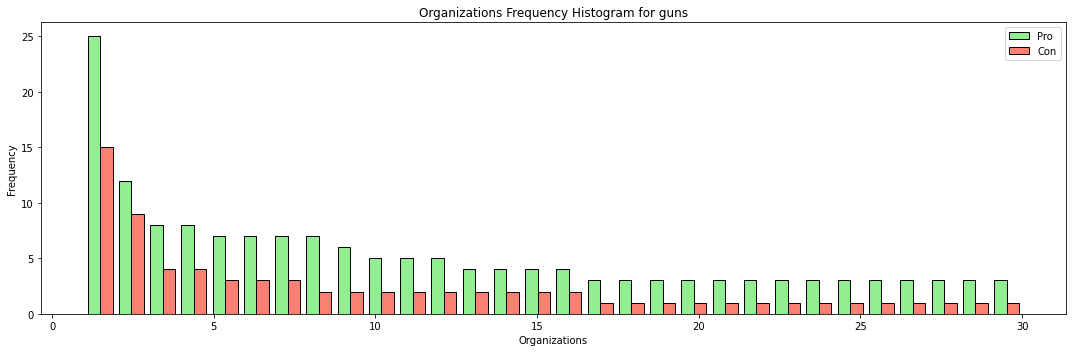

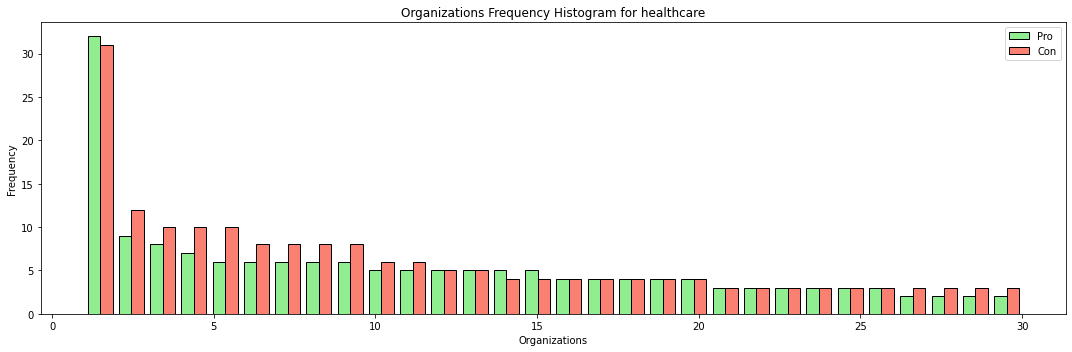

In [20]:
ner_plot_per_stance(top_30_organizations_dictionary, top_30_organizations_dictionary_for_stance1, top_30_organizations_dictionary_for_stance2, 'Organizations')